In [1]:
import numpy as np
from numba import cuda
import time
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022b/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Define a device function
@cuda.jit(device=True)
def gradf(x,delta,wl):
    return 2*x*(1 + delta * math.cos(2*math.pi*x / wl)) - 2*math.pi*x**2 * delta * math.sin(2*math.pi*x / wl) / wl

@cuda.jit(device=True)
def lossf(x,delta,wl):
    return x**2 * (1 + delta * math.cos(2*math.pi*x / wl))

In [3]:
# Define a kernel that uses the device function
@cuda.jit
def GD(tensor, delta, wl, x, steps):
    #tensor : block num, thread num, steps
    ii = cuda.blockIdx.x
    jj = cuda.threadIdx.x
    lr = 1.5 / (tensor.shape[0] * tensor.shape[1] - 1) * (ii * tensor.shape[1] + jj)

    for step in range(steps):
        x = x - lr * gradf(x,delta,wl)
        tensor[ii,jj,step] = lossf(x,delta,wl)

In [4]:
delta, wl = np.float64(1e-3), np.float64(.1)
x=np.float64(1.0)
steps=1000
numblocks = 2**10

tensor = np.zeros((numblocks, 2**10, 1000), dtype = np.float64)
tensord = cuda.to_device(tensor)

# Measure time using time module
start_time = time.time()

GD[numblocks, 2**10](tensord, delta, wl, x, steps)

# Wait for the kernel to finish
cuda.synchronize()

# Measure time using time module
end_time = time.time()

# Copy the result back to host
tensord.copy_to_host(tensor)

print(f"Time taken: {end_time - start_time} seconds")

Time taken: 1.6191439628601074 seconds


In [5]:
bound = 1e+16
timeseries = np.reshape(tensor, (numblocks*2**10,1000))
fin = np.isfinite(timeseries)
timeseries = np.nan_to_num(timeseries, nan=bound)

result = np.zeros((numblocks*2**10,2))

result[timeseries[:,-1]>=bound, 0] = 1
result[timeseries[:,-1]>=bound, 1] = np.sum((timeseries[timeseries[:,-1]>=bound])**(-1),axis = -1)

result[timeseries[:,-1]<bound, 0] = 0
result[timeseries[:,-1]<bound, 1] = np.sum(timeseries[timeseries[:,-1]<bound],axis = -1)

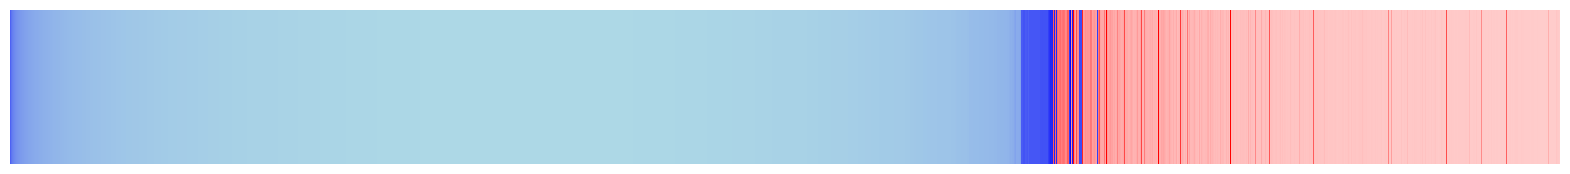

In [17]:
# Sample data (replace with your actual data)
n_points = 2**20
x = np.arange(n_points)
y = result[:,0]  # 0 for convergence, 1 for divergence
z = result[:,1]  # convergence/divergence rate

# Separate convergence and divergence rates
z_convergence = z[y == 0]
z_divergence = z[y == 1]

# Apply logarithmic transformation
z_convergence_log = np.log1p(z_convergence)  # log1p is used to handle values close to zero
z_divergence_log = np.log1p(z_divergence)

# Normalize separately
z_convergence_norm = 3 * (z_convergence_log - z_convergence_log.min()) / (z_convergence_log.max() - z_convergence_log.min())
z_divergence_norm = 3 * (z_divergence_log - z_divergence_log.min()) / (z_divergence_log.max() - z_divergence_log.min())

# Create a normalized z array with the same order as the original data
z_norm = np.zeros_like(z)
z_norm[y == 0] = z_convergence_norm
z_norm[y == 1] = z_divergence_norm

# Create custom colormaps for blue and red, ranging from light to dark
blue_cmap = LinearSegmentedColormap.from_list('blue_cmap', ['#add8e6', 'blue'])  # Light blue to dark blue
red_cmap = LinearSegmentedColormap.from_list('red_cmap', ['#ffcccb', 'red'])  # Light red to dark red

# Create an empty image array
image_height = 1
image_width = n_points
image = np.zeros((image_height, image_width, 3))

# Assign colors using colormaps
for i in range(n_points):
    if y[i] == 0:  # Convergence (blue)
        image[0, i] = blue_cmap(z_norm[i])[:3]  # Use the first three elements (RGB) from the colormap
    else:  # Divergence (red)
        image[0, i] = red_cmap(z_norm[i])[:3]  # Use the first three elements (RGB) from the colormap

# Display the image
plt.figure(figsize=(20, 2))
plt.imshow(image, aspect='auto', interpolation='none')
plt.axis('off')  # Hide the axes
#plt.title('Convergence (Light to Dark Blue) and Divergence (Light to Dark Red) with Intensity Based on Log Rate')
plt.savefig('./visual.pdf')

In [7]:
nn = 20
results =  np.zeros(2**nn+1)
results[1:] = result[:,0]
numB = np.zeros(nn+1)
for ni in range(nn+1):
    nidx = np.arange(2**ni+1) * 2**(nn-ni)
    nresult = results[nidx]
    numB[ni] = np.sum((nresult[:-1] != nresult[1:]).astype(float))

In [8]:
slope, cut = np.linalg.lstsq(np.vstack([np.arange(6,nn+1), np.ones(nn+1-6)]).T , np.log2(numB[6:]), rcond=None)[0]

Text(0, 0.5, 'log#B')

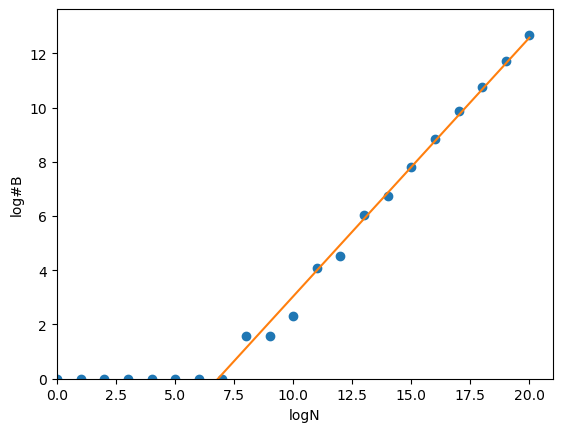

In [9]:
plt.plot(range(nn+1), np.log2(numB),'o')
plt.plot(np.arange(nn+1), slope * np.arange(nn+1) + cut)
plt.xlim(0,)
plt.ylim(0,)
plt.xlabel('logN')
plt.ylabel('log#B')

In [10]:
slope

0.953876517262881